**import important library**

In [1]:
import cv2
import pandas as pd
from torch.utils.data import Dataset
from albumentations import (
    Compose, RandomBrightnessContrast, HueSaturationValue,
    ShiftScaleRotate, HorizontalFlip, Normalize, Resize 
) 
from albumentations.pytorch import ToTensorV2

**Preprocess data**

In [2]:
IMG_SIZE = 224

class GTSRBDataset(Dataset):
    def __init__(self, csv_file, root_dir, img_size = IMG_SIZE, is_train = True):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.img_size = img_size
        self.is_train = is_train

        if is_train:
            self.tf = Compose([
                Resize(img_size, img_size),
                ShiftScaleRotate(shift_limit=0.06, scale_limit= 0.1, rotate_limit =15, p = 0.6),
                RandomBrightnessContrast(p=0.5),
                HueSaturationValue(p=0.4),
                HorizontalFlip(p=0.2),
                Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
                ToTensorV2()
            ])
        else:
            self.tf = Compose([
                Resize(img_size, img_size),
                Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(root_dir, row["Path"])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        label = row["ClassId"]
        img = self.tf(image = img)['image']
        return img, label

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

def build_model(n_classes = 43, backbone = 'resnet18', pretrained = True):
    if backbone == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        in_f = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(in_f, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )
        return model
    else:
        raise ValueError("Unsupported backbone")

**Train & Validate**

In [4]:
import os, argparse, random, math
import numpy as np
from torch.utils.data import DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct, loss_sum = 0, 0 , 0.0
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum  += loss.item() * x.size(0)
        pred= logits.argmax(1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return loss_sum / total, correct/ total

root_dir = "/kaggle/input/gtsrb-german-traffic-sign"
train_csv = os.path.join(root_dir, "Train.csv")
test_csv = os.path.join(root_dir, "Test.csv")
img_size = IMG_SIZE
epochs = 10
batch_size = 64
lr = 3e-4
train_ds = GTSRBDataset(train_csv, root_dir, img_size, is_train= True)
val_ds = GTSRBDataset(test_csv, root_dir, img_size, is_train= False)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = build_model(pretrained=True).to(device)

optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
scaler = torch.cuda.amp.GradScaler() if device=='cuda' else None
criterion = nn.CrossEntropyLoss()

model

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 220MB/s]
/tmp/ipykernel_19/1123934952.py:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if device=='cuda' else None


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)
best_acc, best_ep = 0.0, -1
out = MODEL_PATH / 'best.pt'
backbone = 'resnet18'
for epoch in range(1, epochs+1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
    running_loss = 0.0
    for x, y in pbar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        if scaler:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * x.size(0)
        pbar.set_postfix(loss=running_loss/((pbar.n+1)*x.size(0)))

    scheduler.step()
    val_loss, val_acc = evaluate(model, val_loader, device)
    print(f"[Val] loss={val_loss:.4f} acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc, best_ep = val_acc, epoch
        torch.save({'model': model.state_dict(),
                    'backbone': backbone,
                    'img_size': img_size}, out)
        print(f"Saved best to {out} (acc={best_acc:.4f})")

print(f"Best Acc: {best_acc:.4f} at epoch {best_ep}")

Epoch 1/10:   0%|          | 0/613 [00:00<?, ?it/s]/tmp/ipykernel_19/1979612970.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10: 100%|██████████| 613/613 [03:19<00:00,  3.07it/s, loss=0.571]


[Val] loss=0.1125 acc=0.9699
Saved best to models/best.pt (acc=0.9699)


Epoch 2/10: 100%|██████████| 613/613 [01:34<00:00,  6.51it/s, loss=0.141]


[Val] loss=0.1421 acc=0.9572


Epoch 3/10: 100%|██████████| 613/613 [01:37<00:00,  6.32it/s, loss=0.103]


[Val] loss=0.1076 acc=0.9709
Saved best to models/best.pt (acc=0.9709)


Epoch 4/10: 100%|██████████| 613/613 [01:25<00:00,  7.15it/s, loss=0.0913]


[Val] loss=0.1034 acc=0.9713
Saved best to models/best.pt (acc=0.9713)


Epoch 5/10: 100%|██████████| 613/613 [01:30<00:00,  6.77it/s, loss=0.067]


[Val] loss=0.1318 acc=0.9694


Epoch 6/10: 100%|██████████| 613/613 [01:32<00:00,  6.60it/s, loss=0.0577]


[Val] loss=0.1268 acc=0.9729
Saved best to models/best.pt (acc=0.9729)


Epoch 7/10: 100%|██████████| 613/613 [01:39<00:00,  6.19it/s, loss=0.0458]


[Val] loss=0.1218 acc=0.9749
Saved best to models/best.pt (acc=0.9749)


Epoch 8/10: 100%|██████████| 613/613 [01:34<00:00,  6.47it/s, loss=0.0384]


[Val] loss=0.1371 acc=0.9733


Epoch 9/10: 100%|██████████| 613/613 [01:29<00:00,  6.83it/s, loss=0.0427]


[Val] loss=0.1466 acc=0.9733


Epoch 10/10: 100%|██████████| 613/613 [01:32<00:00,  6.66it/s, loss=0.0299]


[Val] loss=0.1480 acc=0.9741
Best Acc: 0.9749 at epoch 7


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        60
           1     0.9972    1.0000    0.9986       720
           2     0.9973    0.9987    0.9980       750
           3     0.9977    0.9778    0.9877       450
           4     0.9970    0.9970    0.9970       660
           5     0.9559    0.9984    0.9767       630
           6     1.0000    0.9067    0.9510       150
           7     0.9846    0.9956    0.9901       450
           8     0.9977    0.9778    0.9877       450
           9     1.0000    1.0000    1.0000       480
          10     1.0000    1.0000    1.0000       660
          11     0.9976    1.0000    0.9988       420
          12     1.0000    1.0000    1.0000       690
          13     0.9986    0.9972    0.9979       720
          14     1.0000    1.0000    1.0000       270
          15     1.0000    0.9952    0.9976       210
          16     1.0000    1.0000    1.0000       150
          17     1.0000    

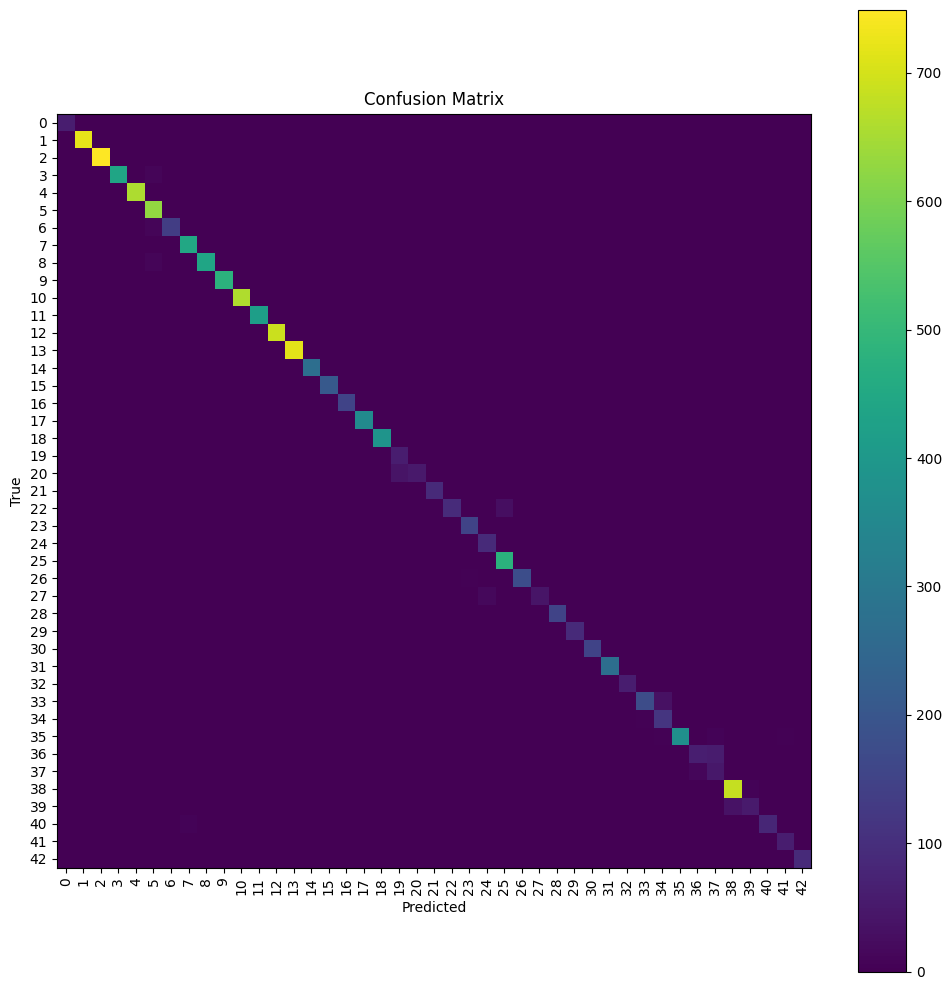

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

model = build_model(pretrained=False).to(device)
model.load_state_dict(torch.load('models/best.pt')['model'])

@torch.no_grad()
def collect_preds(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        pred = logits.argmax(1).cpu().numpy()
        y_pred.append(pred)
        y_true.append(y.numpy())
    return np.concatenate(y_true), np.concatenate(y_pred)

def plot_cm(cm, classes=43, save_path='confusion_matrix.png'):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix'); plt.colorbar()
    ticks = np.arange(classes)
    plt.xticks(ticks, ticks, rotation=90); plt.yticks(ticks, ticks)
    plt.tight_layout()
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.savefig(save_path, dpi=200)
    print(f"Saved {save_path}")
    

y_true, y_pred = collect_preds(model, val_loader, device)
print(classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
plot_cm(cm, classes=43)